In [2]:
import torch
import numpy as np
from pathlib import Path
from PIL import Image
import os
import sys

# PROJECTDIR = os.getcwd()
PROJECTDIR = os.path.normpath(os.path.join(os.getcwd(), "../"))
GAN_DIR = os.path.join(PROJECTDIR, "ganspace")
sys.path.insert(0, GAN_DIR)
sys.path.insert(0, PROJECTDIR)

from ganspace.config import Config
from ganspace.models import get_instrumented_model
from ganspace.decomposition import get_or_compute

import ipywidgets as widgets
from io import BytesIO

StyleGAN2: Optimized CUDA op FusedLeakyReLU not available, using native PyTorch fallback.
StyleGAN2: Optimized CUDA op UpFirDn2d not available, using native PyTorch fallback.


---

In [3]:
class GANModel(object):
    def __init__(self, seed=None):
        torch.autograd.set_grad_enabled(False)
        self.seed = seed
        self.model_name = 'StyleGAN2'
        self.class_name = 'ffhq'
        self.layer_name = 'style'
        self.use_w = 'StyleGAN' in self.model_name
        self.device = torch.device('cpu')
        
        self.gan_model = None
        self.lat_comp = None
        self.lat_mean = None
        self.lat_std = None
        
        self.max_layers = None
        
        self.setup()
    
    def setup_gan_model(self):
        self.inst = get_instrumented_model(self.model_name,
                                           self.class_name,
                                           self.layer_name,
                                           self.device,
                                           use_w=self.use_w)
        self.gan_model = self.inst.model
    
    def setup_pca(self):
        pc_config = Config(
            components=80,
            n=1_000_000,
            batch_size=200,
            layer=self.layer_name,
            model=self.model_name,
            output_class=self.class_name,
            use_w=self.use_w)
        dump_name = get_or_compute(pc_config, self.inst)
        with np.load(dump_name) as data:
            self.lat_comp = data['lat_comp']
            self.lat_mean = data['lat_mean']
            self.lat_std = data['lat_stdev']
    
    def setup(self):
        self.setup_gan_model()
        self.setup_pca()
        self.max_layers = self.gan_model.get_max_latents()
    
    def sample_image(self):
        w = self.gan_model.sample_latent(1, seed=self.seed).cpu().numpy()
        w_list = [w] * self.max_layers
        img = self.gan_model.sample_np(w_list)
        return w, img
    
    def modify_image(self, w, idx, strength, start=None, end=None):
        if (start is None) | (end is None):
            start = 0
            end = self.max_layers - 1
        
        w_list = [w] * self.max_layers
        for l in range(start, end):
            w_list[l] = w_list[l] + self.lat_comp[idx] * strength
        
        img = self.gan_model.sample_np(w_list)
        return w, img

In [4]:
gan = GANModel(seed=1)

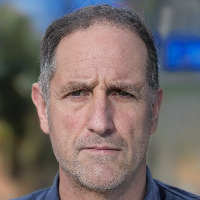

In [5]:
w, img = gan.sample_image()

Image.fromarray((img * 255).astype(np.uint8), mode='RGB').resize((200, 200))

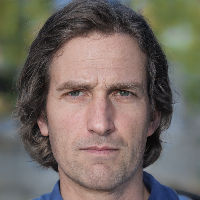

In [6]:
new_w, new_img = gan.modify_image(w, idx=0, strength=5, start=None, end=None)

Image.fromarray((new_img * 255).astype(np.uint8), mode='RGB').resize((200, 200))

---

In [9]:
class GUIses(object):
    def __init__(self):
        self.gan = GANModel(seed=None)
        self.w, self.img = self.gan.sample_image()
        
        max_endL = self.gan.max_layers
        
        self.idx = 0
        self.strength = 0
        self.startL = 1
        self.endL = max_endL
        
        self.widget_idx_slider = widgets.IntSlider(
            min=0, max=79, value=self.idx,
            continuous_update=False, description='idx:')
        self.widget_idx_text = widgets.IntText(
            description="idx:", continuous_update=False)
        
        self.widget_strength_slider = widgets.IntSlider(
            min=-50, max=50, value=self.strength,
            continuous_update=False, description='strength:')
        self.widget_strength_text = widgets.IntText(
            description="strength:", continuous_update=False)
        
        self.widget_startL_text = widgets.IntText(
            description="start layer:", continuous_update=False, value=self.startL)
        
        self.widget_endL_text = widgets.IntText(
            description="end layer:", continuous_update=False, value=self.endL)
        
        self.widget_button = widgets.Button(description="sample new image",
                                            buttin_style="info",
                                            layout=widgets.Layout(width="300px"))
        
        self.widget_image = widgets.Image(format='png', width=300,
                                          value=self.to_bytes(self.img))
    
    def sample(self):
        self.w, self.img = self.gan.sample_image()
    
    def to_bytes(self, img):
        image = Image.fromarray((img * 255).astype(np.uint8), mode='RGB')
        f = BytesIO()
        image.save(f,'png')
        return f.getvalue()
    
    def modify_by_idx(self, idx):
        self.idx = idx
        _, img = self.gan.modify_image(self.w, self.idx, self.strength, self.startL, self.endL)
        return img
    
    def modify_by_strength(self, strength):
        self.strength = strength
        _, img = self.gan.modify_image(self.w, self.idx, self.strength, self.startL, self.endL)
        return img
    
    def modify_by_startL(self, start):
        self.startL = start - 1
        _, img = self.gan.modify_image(self.w, self.idx, self.strength, self.startL, self.endL)
        return img

    def modify_by_endL(self, end):
        self.endL = end - 1
        _, img = self.gan.modify_image(self.w, self.idx, self.strength, self.startL, self.endL)
        return img
    
    def change_idx(self, idx):
        img = self.modify_by_idx(idx.new)
        self.widget_image.value = self.to_bytes(img)
    
    def change_strength(self, strength):
        img = self.modify_by_strength(strength.new)
        self.widget_image.value = self.to_bytes(img)
    
    def change_startL(self, start):
        img = self.modify_by_startL(start.new)
        self.widget_image.value = self.to_bytes(img)
    
    def change_endL(self, end):
        img = self.modify_by_endL(end.new)
        self.widget_image.value = self.to_bytes(img)
    
    def change_img(self, b):
        self.idx = 0
        self.strength = 0
        self.startL = 0
        self.endL = self.gan.max_layers - 1
        
        #self.widget_idx_slider.value
        #self.widget_strength_slider.value
        
        self.widget_startL_text.value = 1
        self.widget_endL_text.value = self.gan.max_layers
        self.widget_idx_text.value = 0
        self.widget_strength_text.value = 0
        
        self.sample()
        self.widget_image.value = self.to_bytes(self.img)
    
    def run(self):
        self.widget_startL_text.observe(self.change_startL, 'value')
        
        self.widget_endL_text.observe(self.change_endL, 'value')
        
        self.widget_idx_text.observe(self.change_idx, 'value')
        #self.widget_idx_slider.observe(self.change_idx, 'value')
        
        self.widget_strength_text.observe(self.change_strength, 'value')
        #self.widget_strength_slider.observe(self.change_strength, 'value')
        
        self.widget_button.on_click(self.change_img)
        
        widgets.link((self.widget_idx_slider, 'value'), (self.widget_idx_text, 'value'))
        widgets.link((self.widget_strength_slider, 'value'), (self.widget_strength_text, 'value'))
        
        run_wid = widgets.VBox([
            self.widget_startL_text, self.widget_endL_text,
            self.widget_idx_slider, self.widget_idx_text,
            self.widget_strength_slider, self.widget_strength_text,
            self.widget_image, self.widget_button])
        
        return run_wid

In [10]:
ses = GUIses()
ses.run()

In [ ]:
# import ipywidgets as widgets
# import IPython
# from io import BytesIO
# from PIL import Image
# from sklearn import datasets

# slider = widgets.IntSlider(min=0, max=len(frames)-1, step=1)

# #convert numpy array to bytes
# img = Image.fromarray(frames[0],mode='RGB')
# f = BytesIO()
# img.save(f,'png')

# image_widget = widgets.Image(
#     value=f.getvalue(),
#     format='png',
#     height = '500px',
#     width = '300px'
# )

# main_layout = widgets.VBox([slider,image_widget])
# display(main_layout)

# # slider handler
# def on_value_change(change):
#     i = change['new']
#     img = Image.fromarray(frames[i],mode='RGB')
#     f = BytesIO()
#     img.save(f,'png')
#     image_widget.value = f.getvalue()
    
# slider.observe(on_value_change, names='value')